# **Exploration & Exploitation**

## Import library

In [133]:
import numpy as np
import matplotlib.pyplot as plt

## Bandit class

In [134]:
class Bandit:
    """Initialize n bandits, each with hidden reward distribution
    """
    def __init__(self, n_bandits, rewards, sd):
        self.n_bandits = n_bandits
        self.rewards = rewards
        self.sd = sd
        # self.rewards = np.random.uniform(-1.0,1.0, self.n_bandits)  # True reward distribute (S.D. = 1.0)
    
    def pull(self, action):
        # print(self.rewards[action])
        return np.random.normal(loc=self.rewards[action], scale=self.sd)
    
# rewards = [0.01, 0.0002, 0.1, 0.3, 0.4]
# bandit = Bandit(5, rewards, 1.0)


## Agent class

In [135]:
class Agent:
    def __init__(self, n_bandits, epsilon=0.1, ucb_c=2):
        self.n_bandits = n_bandits
        self.epsilon = epsilon
        self.ucb_c = ucb_c
        self.q_estimated = np.zeros(n_bandits)  # Estimated reward values
        self.action_counts = np.zeros(n_bandits)  # Action selection counts
        self.total_steps = 0
    
    def select_action_epsilon_greedy(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_bandits)  # Explore
        else:
            return np.argmax(self.q_estimated)  # Exploit
    
    def select_action_ucb(self):
        self.total_steps += 1
        if 0 in self.action_counts:
            return np.argmin(self.action_counts)  # Ensure each action is selected at least once
        ucb_values = self.q_estimated + self.ucb_c * np.sqrt(np.log(self.total_steps) / (self.action_counts + 1e-5))
        return np.argmax(ucb_values)
    
    def update(self, action, reward):
        self.action_counts[action] += 1
        alpha = 1.0 / self.action_counts[action]  # Incremental update rule
        self.q_estimated[action] += alpha * (reward - self.q_estimated[action])

## Simulation Script

In [136]:
def run_experiment(n_bandits, rewards, sd, time_steps, epsilon, ucb=False, ucb_c=2.0):
    bandit = Bandit(n_bandits, rewards, sd)
    agent = Agent(n_bandits, epsilon, ucb_c)
    rewards_log = np.zeros((n_bandits, time_steps))
    
    for t in range(time_steps):
        if ucb:
            action = agent.select_action_ucb()
        else:
            action = agent.select_action_epsilon_greedy()
        
        reward = bandit.pull(action)
        agent.update(action, reward)
        rewards_log[action, t] = reward
    
    return rewards_log

In [137]:
def plot_results(n_bandits, rewards, sd, time_steps, epsilon, ucb_c):
    rewards_epsilon_greedy = run_experiment(n_bandits, rewards, sd, time_steps, epsilon, ucb=False, ucb_c=ucb_c)
    rewards_ucb = run_experiment(n_bandits, rewards, sd, time_steps, epsilon, ucb=True, ucb_c=ucb_c)

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))  # 4 subplots (2 full range, 2 zoomed in)

    last_10_percent = int(time_steps * 0.1)  # Last 10% of time steps
    time_full = np.arange(time_steps) + 1  # Full range
    time_zoom = np.arange(time_steps - last_10_percent, time_steps) + 1  # Last 10%

    # Epsilon-Greedy (Full Range)
    for i in range(n_bandits):
        axes[0, 0].plot(time_full, np.cumsum(rewards_epsilon_greedy[i, :]) / time_full, label=f"Bandit {i}")

    axes[0, 0].set_xscale("log")
    axes[0, 0].set_title(f"Epsilon-Greedy Strategy (ε = {epsilon})")
    axes[0, 0].set_xlabel("Time Steps (Log Scale)")
    axes[0, 0].set_ylabel("Average Reward")
    axes[0, 0].legend(loc="upper left", bbox_to_anchor=(1.05, 1))
    axes[0, 0].grid(True, which="both", linestyle="--", linewidth=0.5)

    # UCB (Full Range)
    for i in range(n_bandits):
        axes[0, 1].plot(time_full, np.cumsum(rewards_ucb[i, :]) / time_full, label=f"Bandit {i}")

    axes[0, 1].set_xscale("log")
    axes[0, 1].set_title(f"Upper Confidence Bound (UCB) Strategy (c={ucb_c})")
    axes[0, 1].set_xlabel("Time Steps (Log Scale)")
    axes[0, 1].set_ylabel("Average Reward")
    axes[0, 1].legend(loc="upper left", bbox_to_anchor=(1.05, 1))
    axes[0, 1].grid(True, which="both", linestyle="--", linewidth=0.5)

    # Epsilon-Greedy (Last 10%)
    for i in range(n_bandits):
        axes[1, 0].plot(time_zoom, np.cumsum(rewards_epsilon_greedy[i, -last_10_percent:]) / time_zoom, label=f"Bandit {i}")

    axes[1, 0].set_xscale("linear")  # No log scale for zoomed-in view
    axes[1, 0].set_title(f"Epsilon-Greedy Strategy (Last 10% of Timesteps)")
    axes[1, 0].set_xlabel("Time Steps (Linear Scale)")
    axes[1, 0].set_ylabel("Average Reward")
    axes[1, 0].grid(True, linestyle="--", linewidth=0.5)

    # UCB (Last 10%)
    for i in range(n_bandits):
        axes[1, 1].plot(time_zoom, np.cumsum(rewards_ucb[i, -last_10_percent:]) / time_zoom, label=f"Bandit {i}")

    axes[1, 1].set_xscale("linear")  # No log scale for zoomed-in view
    axes[1, 1].set_title(f"Upper Confidence Bound (UCB) Strategy (Last 10% of Timesteps)")
    axes[1, 1].set_xlabel("Time Steps (Linear Scale)")
    axes[1, 1].set_ylabel("Average Reward")
    axes[1, 1].grid(True, linestyle="--", linewidth=0.5)

    plt.suptitle("Comparison of Epsilon-Greedy and UCB Algorithms (Full & Zoomed-In)", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

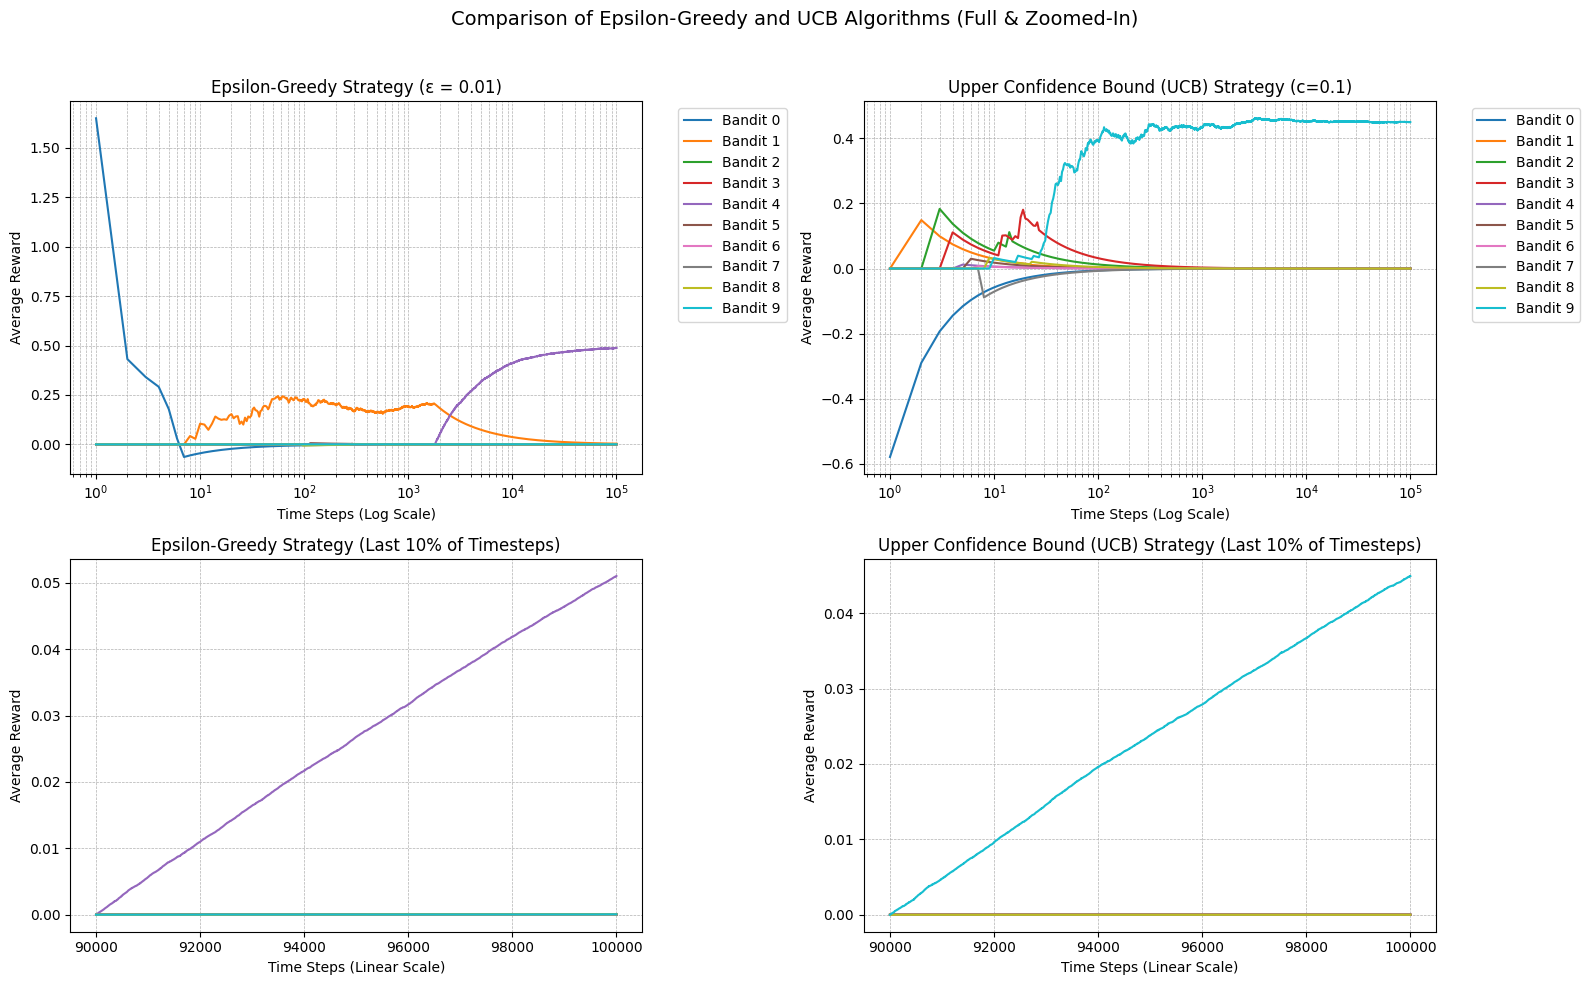

In [140]:
# Define rewards for the bandits
rewards = [0.1, 0.2, 0.3, 0.4, 0.5,0.01, 0.02, 0.03, 0.35, 0.45]

# Running and plotting the experiment
plot_results(n_bandits=10, rewards=rewards, sd=0.5, time_steps=100000, epsilon=0.01, ucb_c=0.1)